In [149]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [150]:
# relevant constants

c = 3e10
k = 1.381e-16
pc = 3.086e18

In [151]:
# function describing sky brightness, based on sky coordinates, 
# geometry of disk/halo, and power densities of each

def LineOfSight(l, b, d, R_disk, h_disk, R_halo):
    
    # l and b given in degrees (as from hp.pix2ang) - convert to radians
    # d = distance of sun from center of galaxy
    
    l = np.deg2rad(l)
    b = np.deg2rad(b)
    
    # first calculate length of line of sight through disk
    l = np.min([l, (2*np.pi)-l])
    b = np.abs(b)
    B_disk = np.pi - l - np.arcsin((d/R_disk)*np.sin(l))
    r_disk = np.sqrt((R_disk**2) + (d**2) - (2*R_disk*d*np.cos(B_disk)))
    
    if b <= np.arctan(0.5*h_disk/r_disk):
        D_disk = r_disk/(np.cos(b))
        
    else: 
        D_disk = 0.5*h_disk/(np.sin(b))
        
    # next calculate length of line of sight through halo
    
    b_ = np.pi - b
    
    d_proj = d*np.abs(np.cos(l))
    B_halo1 = np.pi - l - np.arcsin((d/R_halo)*np.sin(l))
    
    if l > np.pi/2:
        b = b_
        R_eff = np.sqrt((R_halo**2) + (d**2) - (2*R_halo*d*np.cos(B_halo1))) + d_proj
        
    else: 
        R_eff = np.sqrt((R_halo**2) + (d**2) - (2*R_halo*d*np.cos(B_halo1))) - d_proj
    
    B_halo = np.pi - b - np.arcsin((d_proj/R_eff)*np.sin(b))
    
    D_tot = np.sqrt((R_eff**2) + (d_proj**2) - (2*R_eff*d_proj*np.cos(B_halo)))
    D_halo = D_tot
    
    if D_halo < 0:
        D_halo = 0
    
    return [D_disk,D_halo]

def SkyBrightness(D_disk, D_halo, p_disk, p_halo):
    
        
    # flux density (erg s^-1 cm^-2 Hz^-1) = power density * distance 
    F = p_disk*D_disk + p_halo*D_halo
    
    return F
    
   
        
    

In [152]:
# get coordinates for each pixel of a map of a given size
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
m = np.arange(NPIX)
coords = hp.pix2ang(NSIDE, m, lonlat=True)
l = coords[0]
b = coords[1]

1.0411715987433933e-41
5.249652526505947e-41
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


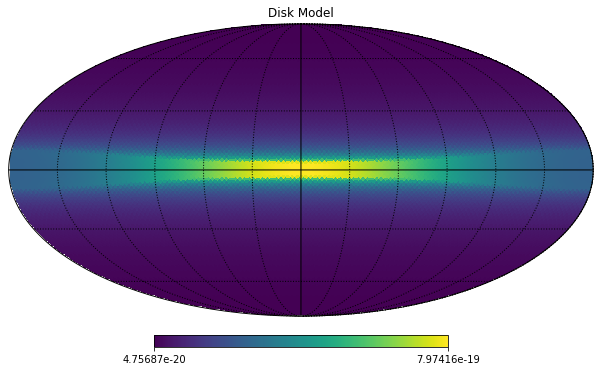

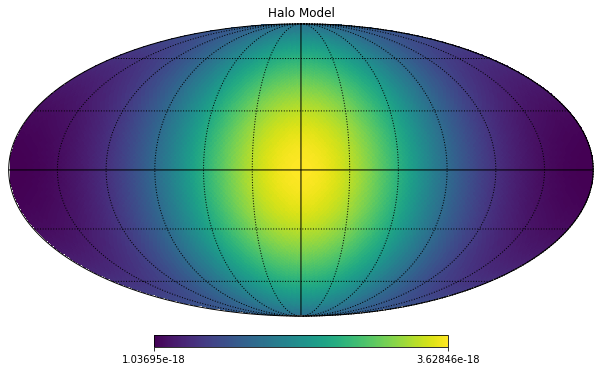

In [153]:
# 1420 MHz values taken from Subrahmanyan paper
# all distances in paper given in units of the solar circle

nu = 1420e6
T_disk = 0.79 # defined at poles
T_halo = 0.3
d = 8e3*pc # distance from galactic center to sun ~8kpc
R_disk = 2.1*d
h_disk = 0.37*d
R_halo = 1.8*d

# need to verify this calculation is correct
p_disk = 4*np.pi*np.arctan(0.5*h_disk/R_disk)*(2*(nu**2)/c**2)*k*T_disk*(1/R_disk)
p_halo = (4*np.pi)*(2*(nu**2)/c**2)*k*T_halo*(1/R_halo)

print(p_disk)
print(p_halo)

pix_disk = []
pix_halo = []
d_disk = []
d_halo = []

for i in np.arange(NPIX):
    
    los = LineOfSight(l[i], b[i], d, R_disk, h_disk, R_halo)
    d_disk.append(los[0])
    d_halo.append(los[1])
    
    pix_disk.append(los[0]*p_disk)
    pix_halo.append(los[1]*p_halo)


    
pix_disk = np.array(pix_disk)
pix_halo = np.array(pix_halo)

hp.mollview(pix_disk, title="Disk Model")
hp.graticule()

hp.mollview(pix_halo, title = "Halo Model")
hp.graticule()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


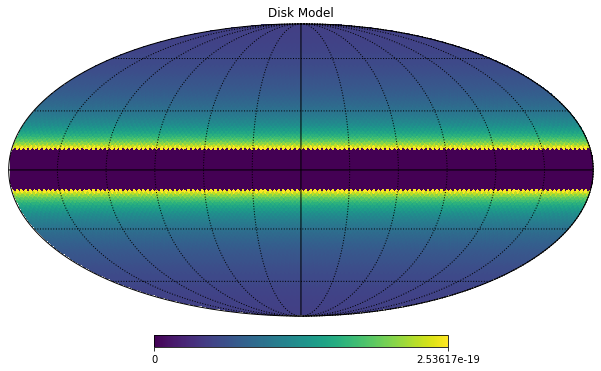

In [154]:
# Mask all pixels between -10 < b < +10 by setting them all to zero

idx = hp.query_strip(NSIDE, np.deg2rad(90-10), np.deg2rad(90+10))
pix_disk[idx] = 0

hp.mollview(pix_disk, title="Disk Model")
hp.graticule()

Text(0.5, 1.0, 'Mean Sky Brightness Profile of Disk Model')

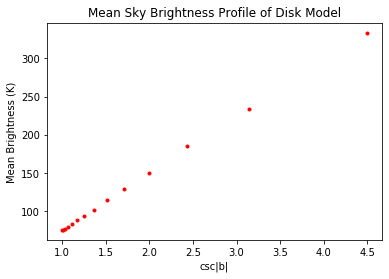

In [162]:
# Construact a T_b vs csc(b) graph

b_range = np.linspace(10,90,15)

# number of steradians per pixel
sr = hp.nside2pixarea(NSIDE)

cscb = []
Tb = []
b_ = []

for i in range(len(b_range)-1):
    
    b1 = 90 - b_range[i]
    b2 = 90 - b_range[i+1]
    
    bmid = 0.5*(b_range[i] + b_range[1+i])
    
    b_.append(bmid)
    
    cscb.append(1/(np.sin(np.deg2rad(bmid)))) 
    
    idx = hp.query_strip(NSIDE, np.deg2rad(b2), np.deg2rad(b1))
    I_v = np.mean(pix_disk[idx])/sr
    
    T = I_v*c**2/(2*k*nu**2)
    Tb.append(T)

plt.figure(0)
plt.plot(cscb,Tb,'r.')
plt.xlabel('csc|b|')
plt.ylabel('Mean Brightness (K)')
plt.title('Mean Sky Brightness Profile of Disk Model')

    
    